In [4]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist

In [6]:
xa=np.linspace(0,2*np.pi,20)
ya=np.sin(xa)

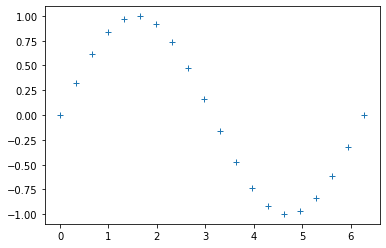

In [8]:
plt.plot(xa,ya,"+")

In [ ]:
#interpolation

In [10]:
def f(x):
    return jnp.interp(x,xa,ya)

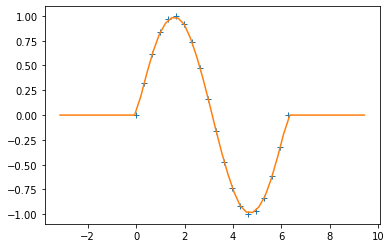

In [30]:
x=np.linspace(-np.pi,3*np.pi,50)
plt.plot(xa,ya,"+")
plt.plot(x,f(x))

In [15]:
from jax import grad,vmap

In [31]:
g=vmap(grad(f))

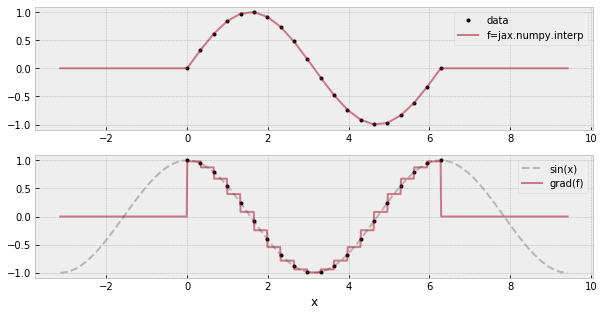

In [86]:
xx=np.linspace(-np.pi,3*np.pi,1000)
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(xa,ya,".",label="data",color="black")
plt.plot(xx,f(xx),label="f=jax.numpy.interp",color="C1",alpha=0.5)
plt.legend()
ax=fig.add_subplot(212)
plt.plot(xx,np.cos(xx),ls="dashed",label="sin(x)",color="gray",alpha=0.5)
plt.plot(xa,np.cos(xa),".",color="black")
plt.plot(xx,g(xx),label="grad(f)",color="C1",alpha=0.5)

plt.legend()
plt.xlabel("x")
plt.savefig("interp.pdf")

In [ ]:
# NUTS

In [94]:
xb=np.linspace(0.5,1.7,10)
c=0.3
sigin=0.5
A=10.0
y=A*np.sin(xb+c)+np.random.normal(0,sigin,size=len(xb))

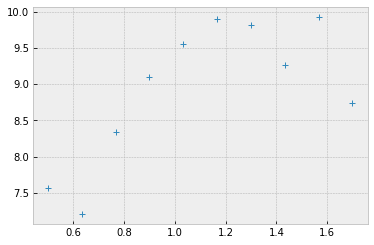

In [95]:
plt.plot(xb,y,"+")

In [96]:
import numpyro
import numpyro.distributions as dist

def model(x,y):
    c = numpyro.sample('c', dist.Uniform(-0.5, 0.5))
    A = numpyro.sample('A', dist.Uniform(0.1,100))
    sigma = numpyro.sample('sigma', dist.Exponential(1.0))
    mu=A*f(x+c)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [97]:
from jax import random
from numpyro.infer import MCMC, NUTS

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, x=xb, y=y)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:07<00:00, 402.04it/s, 3 steps of size 5.83e-01. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      9.88      0.19      9.88      9.55     10.18   1079.79      1.00
         c      0.29      0.05      0.29      0.22      0.37   1066.31      1.00
     sigma      0.49      0.14      0.46      0.26      0.66   1007.53      1.01

Number of divergences: 0


In [98]:
samples = mcmc.get_samples()

In [99]:
posterior_c = mcmc.get_samples()['c']
posterior_A = mcmc.get_samples()['A']
posterior_sigma = mcmc.get_samples()['sigma']

In [100]:
from numpyro.infer import Predictive
pred = Predictive(model,{'c':posterior_c,'A':posterior_A,'sigma':posterior_sigma},return_sites=["y"])
x_ = jnp.linspace(-0.5*np.pi,2.5*jnp.pi,1000)
predictions = pred(rng_key_,x=x_,y=None)

In [101]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(predictions["y"], axis=0)
hpdi_muy = hpdi(predictions["y"], 0.9)

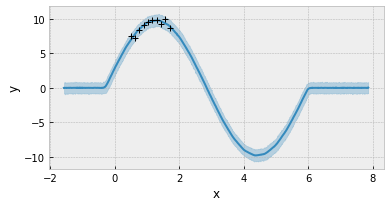

In [102]:
import seaborn as sns
plt.style.use('bmh')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))

ax.plot(x_,mean_muy,color="C0")
ax.fill_between(x_, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")
ax.plot(xb,y,"+",color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("interpfit.pdf")